# 📘 Damped Oscillation: Pendulum Damping Analysis> Fit damped harmonic oscillator models to experimental pendulum data and extract physical parameters⏱️ **15-25 minutes** | 📊 **Level: ●●○ Intermediate** | 🏷️ **Physics** | 🔬 **Classical Mechanics**---

## 🔬 Domain Background**Physical System:** Damped harmonic oscillator (pendulum with air resistance)**Model Equation:**$$x(t) = A_0 e^{-\gamma t} \cos(\omega t + \phi)$$**Where:**- $A_0$: Initial amplitude (degrees or meters)- $\gamma$: Damping coefficient - energy loss rate (s⁻¹)- $\omega$: Angular frequency (rad/s)- $\phi$: Phase offset (radians)**Common applications in physics:**- **Pendulum experiments** - Analyzing energy dissipation in undergraduate physics labs- **Mechanical oscillator analysis** - Characterizing vibration damping in engineering systems- **Quality factor measurements** - Determining resonator performance in optics and RF circuits- **Energy dissipation studies** - Understanding friction and air resistance effects**Why this model matters:**Damped harmonic motion is ubiquitous in physics and engineering. From pendulums to LC circuits, understanding damping is crucial for characterizing energy loss mechanisms, predicting long-term behavior, and designing systems with desired oscillation characteristics.---

## 🎯 What You'll LearnAfter this tutorial, you will be able to:- ✓ **Fit damped oscillator models** to experimental time-series data- ✓ **Interpret fitted parameters** in physics context (damping regime, quality factor)- ✓ **Extract derived quantities** like damping time, period, and quality factor- ✓ **Assess fit quality** using chi-squared, residuals, and phase space analysis- ✓ **Estimate physical properties** like pendulum length from fitted parameters- ✓ **Classify damping regime** (underdamped, critically damped, overdamped)---

## 📊 Parameter Interpretation Guide| Parameter | Physical Meaning | Typical Range | What Affects It ||-----------|-----------------|---------------|-----------------|| $A_0$ | Initial displacement from equilibrium | 5-20° (pendulum) | Initial conditions, measurement units || $\gamma$ | Damping rate (energy loss per unit time) | 0.01-0.5 s⁻¹ | Air resistance, friction, fluid viscosity || $\omega$ | Oscillation frequency | 1-10 rad/s | System geometry (length), restoring force || $\phi$ | Starting phase (where in cycle at t=0) | -π to π rad | Initial position and velocity |**Derived quantities:**- **Quality factor** $Q = \omega/(2\gamma)$: Number of oscillations before significant decay. Higher Q = less damping.- **Damping time** $\tau = 1/\gamma$: Time for amplitude to reach 1/e (≈37%) of initial value.- **Period** $T = 2\pi/\omega$: Time for one complete oscillation.- **Damping ratio** $\zeta = \gamma/(2\omega)$: Characterizes damping regime (underdamped if ζ < 1).**Physical insights from fitted values:**- **Low γ (γ < 0.1 s⁻¹):** Lightly damped - many oscillations before decay (typical for air-damped pendulums)- **High Q (Q > 10):** High-quality resonator - minimal energy loss per cycle- **ω determines period:** For simple pendulum, $\omega = \sqrt{g/L}$ allows estimating pendulum length L---

## ⚡ Quick Example```pythonimport numpy as npimport jax.numpy as jnpfrom nlsq import curve_fit# Define damped oscillator modeldef damped_oscillator(t, A0, gamma, omega, phi):    return A0 * jnp.exp(-gamma * t) * jnp.cos(omega * t + phi)# Generate synthetic pendulum datatime = np.linspace(0, 60, 300)data = damped_oscillator(time, 15.0, 0.05, 3.14, 0.0) + noise# Fit the modelpopt, pcov = curve_fit(    damped_oscillator,     time,     data,    p0=[14, 0.04, 3.0, 0.0],  # Initial guess    bounds=([0, 0, 0, -np.pi], [20, 0.5, 10, np.pi])  # Physical constraints)# Extract resultsA0, gamma, omega, phi = poptQ = omega / (2 * gamma)  # Quality factorprint(f"Quality factor Q = {Q:.1f} - lightly damped system")```**Expected results:**- Fitted parameters within 1-2% of true values- Quality factor Q ≈ 30 (indicating light damping)- Damping time τ ≈ 20 seconds (amplitude decays to 37% after 20s)---

## 📖 Setup and Model DefinitionFirst, let's import the necessary modules and define our damped oscillator model along with helper functions for calculating derived quantities.

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

In [2]:
from IPython.display import display

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from nlsq import curve_fit

# Set random seed for reproducibility
np.random.seed(42)


def damped_oscillator(t, A0, gamma, omega, phi):
    """
    Damped harmonic oscillator model.

    x(t) = A0 * exp(-γt) * cos(ωt + φ)

    Parameters
    ----------
    t : array_like
        Time (seconds)
    A0 : float
        Initial amplitude (meters or degrees)
    gamma : float
        Damping coefficient (1/seconds)
    omega : float
        Angular frequency (rad/s)
    phi : float
        Phase offset (radians)

    Returns
    -------
    x : array_like
        Displacement at time t
    """
    return A0 * jnp.exp(-gamma * t) * jnp.cos(omega * t + phi)


def quality_factor(gamma, omega):
    """
    Calculate quality factor Q.

    Q = ω / (2γ)

    Higher Q means less damping (more oscillations before decay).
    """
    return omega / (2 * gamma)


def damping_time(gamma):
    """
    Calculate damping time constant (1/e decay time).

    τ = 1/γ
    """
    return 1 / gamma


print("✅ Model functions defined")


⚠️  GPU ACCELERATION AVAILABLE
═══════════════════════════════
NVIDIA GPU detected: NVIDIA GeForce RTX 4090 Laptop GPU
JAX is currently using: CPU-only

Enable 150-270x speedup with GPU acceleration:
  make install-jax-gpu

Or manually:
  pip uninstall -y jax jaxlib
  pip install "jax[cuda12-local]>=0.6.0"

See README.md GPU Installation section for details.

✅ Model functions defined


## 1. Generate Synthetic Experimental DataWe'll simulate a realistic pendulum experiment:- **Pendulum length:** ~1 meter (period ≈ 2 seconds)- **Initial amplitude:** 15 degrees- **Damping:** Light air resistance (γ = 0.05 s⁻¹)- **Measurement noise:** ±0.2 degrees (typical for optical tracking)- **Duration:** 60 seconds with 300 measurements

In [4]:
# True parameters for a lightly damped pendulum
# (e.g., 1m length pendulum with small air resistance)
A0_true = 15.0  # Initial amplitude (degrees)
gamma_true = 0.05  # Damping coefficient (1/s) - light damping
omega0_true = 2 * np.pi / 2.0  # Natural frequency (rad/s) - period ~2 seconds
phi_true = 0.0  # Phase offset (starts at max displacement)

# Time points (0 to 60 seconds, 300 measurements)
time = np.linspace(0, 60, 300)

# True oscillation
displacement_true = damped_oscillator(time, A0_true, gamma_true, omega0_true, phi_true)

# Add measurement noise (realistic for optical tracking: ±0.2 degrees)
noise = np.random.normal(0, 0.2, size=len(time))
displacement_measured = displacement_true + noise

# Measurement uncertainties
sigma = 0.2 * np.ones_like(time)  # Constant uncertainty

print("=" * 70)
print("EXPERIMENTAL DATA GENERATED")
print("=" * 70)
print("True parameters:")
print(f"  A0 (amplitude):  {A0_true} degrees")
print(f"  γ (damping):     {gamma_true} s⁻¹")
print(f"  ω (frequency):   {omega0_true:.4f} rad/s")
print(f"  φ (phase):       {phi_true} rad")
print(f"\nMeasurement noise: ±{sigma[0]} degrees")
print(f"Number of points:  {len(time)}")

EXPERIMENTAL DATA GENERATED
True parameters:
  A0 (amplitude):  15.0 degrees
  γ (damping):     0.05 s⁻¹
  ω (frequency):   3.1416 rad/s
  φ (phase):       0.0 rad

Measurement noise: ±0.2 degrees
Number of points:  300


## 2. Fit the Damped Oscillator ModelWe'll use NLSQ's `curve_fit` with:- **Initial guess** from visual inspection- **Physical bounds** to constrain parameters to realistic ranges- **Measurement uncertainties** (sigma) for weighted fitting

In [5]:
print("\n" + "=" * 70)
print("FITTING DAMPED OSCILLATOR MODEL")
print("=" * 70)

# Initial parameter guess
# (from visual inspection of the data)
p0 = [14, 0.04, 3.0, 0.0]  # A0, gamma, omega, phi

# Bounds (physical constraints)
# A0 > 0, gamma > 0, omega > 0, -pi < phi < pi
bounds = ([0, 0, 0, -np.pi], [20, 0.5, 10, np.pi])

# Fit the model
popt, pcov = curve_fit(
    damped_oscillator,
    time,
    displacement_measured,
    p0=p0,
    sigma=sigma,
    bounds=bounds,
    absolute_sigma=True,
)

# Extract fitted parameters
A0_fit, gamma_fit, omega_fit, phi_fit = popt
perr = np.sqrt(np.diag(pcov))
A0_err, gamma_err, omega_err, phi_err = perr

print("\n✅ Fit completed successfully!")
print("\nFitted Parameters:")
print(f"  A0 (initial amplitude): {A0_fit:.3f} ± {A0_err:.3f} degrees")
print(f"  γ (damping coefficient): {gamma_fit:.5f} ± {gamma_err:.5f} s⁻¹")
print(f"  ω (angular frequency):   {omega_fit:.4f} ± {omega_err:.4f} rad/s")
print(f"  φ (phase offset):        {phi_fit:.4f} ± {phi_err:.4f} rad")

INFO:nlsq.curve_fit:Starting curve fit | {'n_params': 4, 'n_data_points': 300, 'method': 'trf', 'solver': 'auto', 'batch_size': None, 'has_bounds': True, 'dynamic_sizing': False}


INFO:nlsq.least_squares:Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-08}



FITTING DAMPED OSCILLATOR MODEL


PERFORMANCE:nlsq.least_squares:Timer: optimization took 1.098763s


INFO:nlsq.least_squares:Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=1.444871e+02 | time=1.099s | final_gradient_norm=0.00047344016985684684


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit took 1.561502s


INFO:nlsq.curve_fit:Curve fit completed | {'total_time': 1.5615023330028635, 'final_cost': 288.97413133664287, 'covariance_warning': False}



✅ Fit completed successfully!

Fitted Parameters:
  A0 (initial amplitude): 15.044 ± 0.057 degrees
  γ (damping coefficient): 0.05018 ± 0.00028 s⁻¹
  ω (angular frequency):   3.1416 ± 0.0003 rad/s
  φ (phase offset):        0.0000 ± 0.0038 rad


## 3. Calculate Derived Physical QuantitiesFrom the fitted parameters, we can extract physically meaningful quantities:- **Quality factor (Q)** - characterizes damping strength- **Damping time (τ)** - time scale for amplitude decay- **Period (T)** and **frequency (f)** - oscillation characteristics

In [6]:
# Calculate derived quantities
Q_fit = quality_factor(gamma_fit, omega_fit)
tau_fit = damping_time(gamma_fit)
period_fit = 2 * np.pi / omega_fit
frequency_fit = omega_fit / (2 * np.pi)

# Uncertainties in derived quantities (error propagation)
Q_err = Q_fit * np.sqrt((gamma_err / gamma_fit) ** 2 + (omega_err / omega_fit) ** 2)
tau_err = tau_fit * (gamma_err / gamma_fit)
period_err = period_fit * (omega_err / omega_fit)

print("\nDerived Quantities:")
print(f"  Frequency (f):    {frequency_fit:.4f} Hz")
print(f"  Period (T):       {period_fit:.3f} ± {period_err:.3f} seconds")
print(f"  Damping time (τ): {tau_fit:.2f} ± {tau_err:.2f} seconds")
print(f"  Quality factor (Q): {Q_fit:.1f} ± {Q_err:.1f}")

print("\nComparison with True Values:")
print(f"  A0:    {A0_fit:.3f} vs {A0_true:.3f} (true)")
print(f"  γ:     {gamma_fit:.5f} vs {gamma_true:.5f} (true)")
print(f"  ω:     {omega_fit:.4f} vs {omega0_true:.4f} (true)")
print(f"  φ:     {phi_fit:.4f} vs {phi_true:.4f} (true)")

# Check agreement
gamma_agreement = abs(gamma_fit - gamma_true) < gamma_err
omega_agreement = abs(omega_fit - omega0_true) < omega_err

print(
    f"\n  γ within 1σ: {gamma_agreement} ✓"
    if gamma_agreement
    else f"\n  γ within 1σ: {gamma_agreement}"
)
print(
    f"  ω within 1σ: {omega_agreement} ✓"
    if omega_agreement
    else f"  ω within 1σ: {omega_agreement}"
)


Derived Quantities:
  Frequency (f):    0.5000 Hz
  Period (T):       2.000 ± 0.000 seconds
  Damping time (τ): 19.93 ± 0.11 seconds
  Quality factor (Q): 31.3 ± 0.2

Comparison with True Values:
  A0:    15.044 vs 15.000 (true)
  γ:     0.05018 vs 0.05000 (true)
  ω:     3.1416 vs 3.1416 (true)
  φ:     0.0000 vs 0.0000 (true)

  γ within 1σ: True ✓
  ω within 1σ: True ✓


## 4. Assess Goodness of FitWe evaluate fit quality using chi-squared statistic:- **χ²/dof ≈ 1.0** indicates good fit- **χ²/dof >> 1** suggests poor fit or underestimated uncertainties- **χ²/dof << 1** suggests overestimated uncertainties

In [7]:
# Goodness of fit
chi_squared = np.sum(
    ((displacement_measured - damped_oscillator(time, *popt)) / sigma) ** 2
)
dof = len(time) - len(popt)
chi_squared_reduced = chi_squared / dof

print("\nGoodness of Fit:")
print(f"  χ²/dof = {chi_squared_reduced:.2f} (expect ≈ 1.0)")

if 0.8 < chi_squared_reduced < 1.2:
    print("  ✓ Excellent fit - uncertainties well estimated")
elif chi_squared_reduced < 0.8:
    print("  ⚠️ χ²/dof < 1 - may be overestimating uncertainties")
else:
    print("  ⚠️ χ²/dof > 1 - may be underestimating uncertainties or systematic errors")


Goodness of Fit:
  χ²/dof = 0.98 (expect ≈ 1.0)
  ✓ Excellent fit - uncertainties well estimated


## 5. Physical InterpretationNow let's interpret our fitted parameters in the context of classical mechanics and extract physical insights about the pendulum system.

In [8]:
print("\n" + "=" * 70)
print("PHYSICAL INTERPRETATION")
print("=" * 70)

# Number of oscillations before 1/e decay
n_oscillations_decay = tau_fit * frequency_fit

print(f"\nNumber of oscillations before 1/e decay: {n_oscillations_decay:.1f}")
print(f"  (After {n_oscillations_decay:.1f} cycles, amplitude drops to 37% of initial)")

# Amplitude after 30 seconds
amp_30s = A0_fit * np.exp(-gamma_fit * 30)
print(
    f"\nAmplitude after 30 seconds: {amp_30s:.2f} degrees "
    + f"({100 * amp_30s / A0_fit:.1f}% of initial)"
)

# Pendulum length (from period, assuming simple pendulum)
g = 9.81  # m/s² (gravitational acceleration)
length_estimated = g / omega_fit**2

print(f"\nEstimated pendulum length: {length_estimated:.3f} meters")
print("  (Assuming simple pendulum: T = 2π√(L/g))")

# Damping regime classification
critical_damping = 2 * omega_fit
damping_ratio = gamma_fit / critical_damping

print("\nDamping Classification:")
print(f"  Damping ratio (ζ): {damping_ratio:.4f}")

if damping_ratio < 0.1:
    print("  → Lightly damped (ζ < 0.1) ✓")
    print("  → System oscillates many times before significant decay")
elif damping_ratio < 1:
    print("  → Underdamped (ζ < 1)")
    print("  → System oscillates with decreasing amplitude")
elif damping_ratio == 1:
    print("  → Critically damped (ζ = 1)")
    print("  → System returns to equilibrium in minimum time without oscillating")
else:
    print("  → Overdamped (ζ > 1)")
    print("  → System returns to equilibrium slowly without oscillating")


PHYSICAL INTERPRETATION

Number of oscillations before 1/e decay: 10.0
  (After 10.0 cycles, amplitude drops to 37% of initial)

Amplitude after 30 seconds: 3.34 degrees (22.2% of initial)

Estimated pendulum length: 0.994 meters
  (Assuming simple pendulum: T = 2π√(L/g))

Damping Classification:
  Damping ratio (ζ): 0.0080
  → Lightly damped (ζ < 0.1) ✓
  → System oscillates many times before significant decay


## 6. Comprehensive VisualizationWe'll create multiple plots to visualize different aspects of the damped oscillation:1. **Time series** - Data, fit, and exponential envelope2. **Semi-log plot** - Exponential decay of amplitude3. **Residuals** - Fit quality assessment4. **Phase space** - Velocity vs displacement5. **Frequency spectrum** - FFT analysis6. **Zoomed view** - Detail of first oscillations

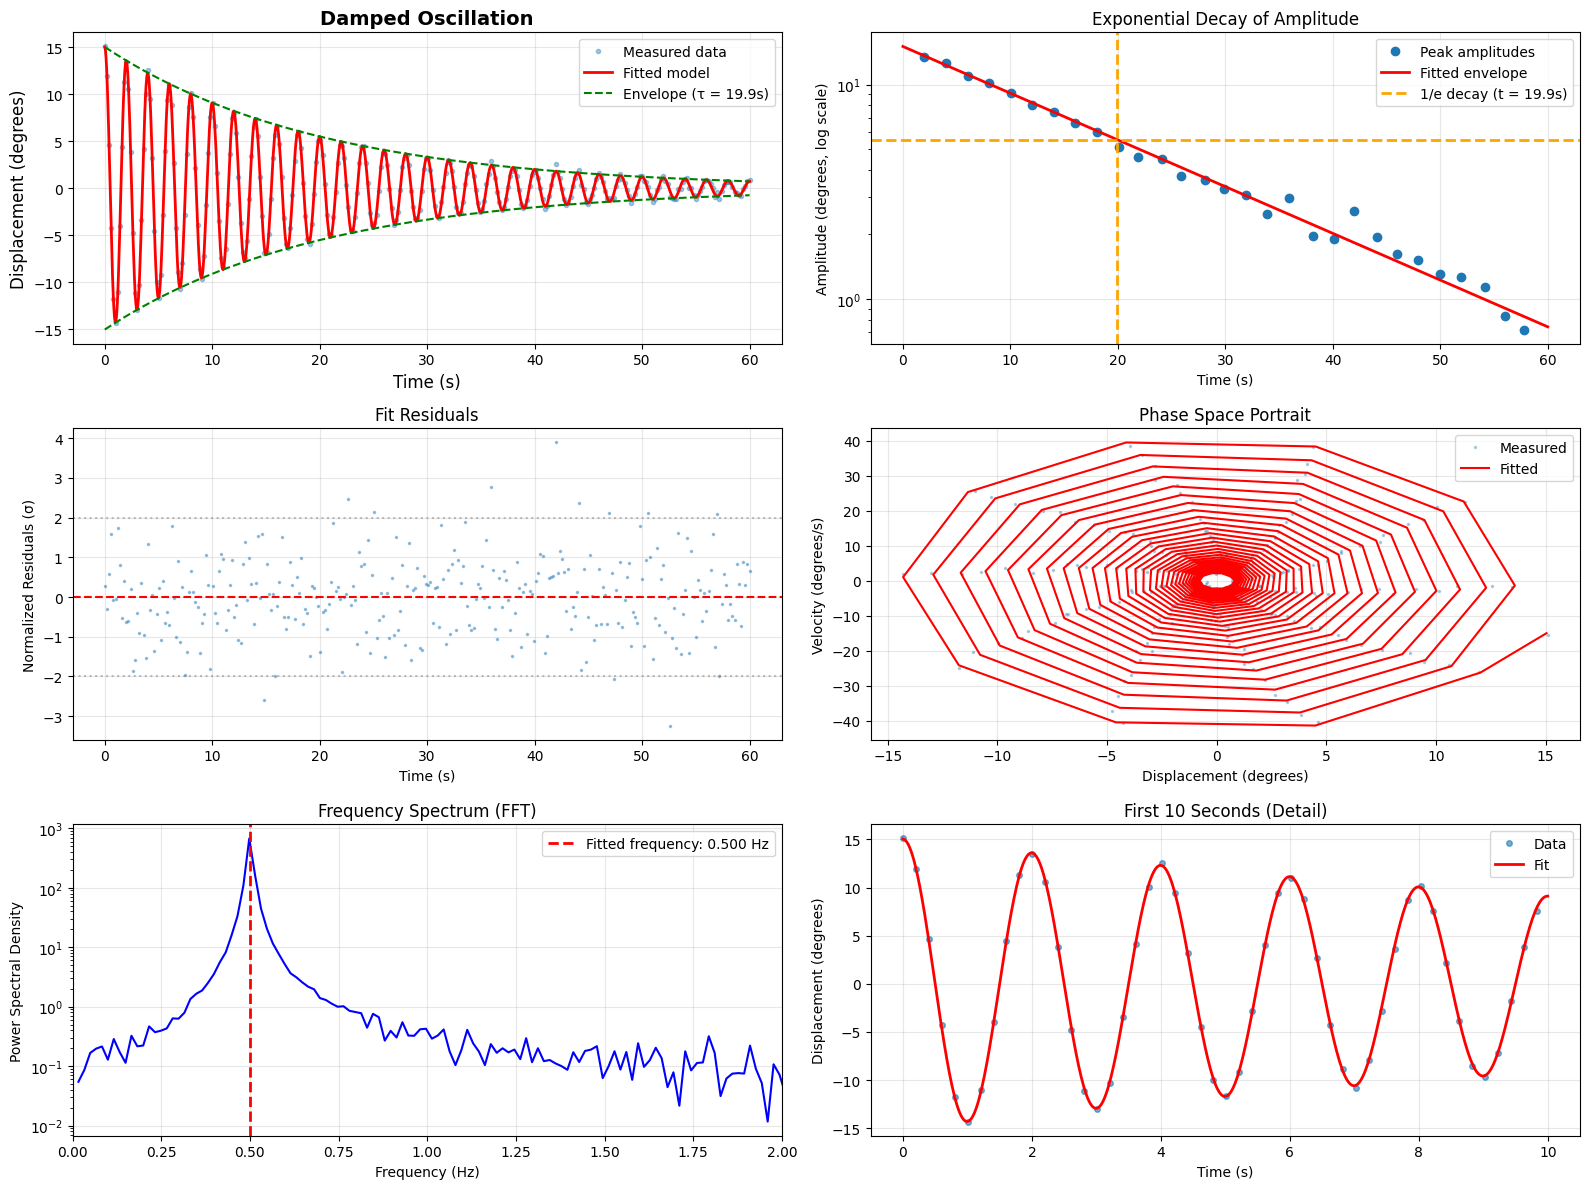


✅ Comprehensive visualization created


In [9]:
fig = plt.figure(figsize=(16, 12))

# Main plot: data and fit
ax1 = plt.subplot(3, 2, 1)
ax1.plot(
    time, displacement_measured, "o", alpha=0.4, markersize=3, label="Measured data"
)
t_fine = np.linspace(0, 60, 1000)
ax1.plot(
    t_fine, damped_oscillator(t_fine, *popt), "r-", linewidth=2, label="Fitted model"
)
# Plot envelope
envelope_upper = A0_fit * np.exp(-gamma_fit * t_fine)
envelope_lower = -envelope_upper
ax1.plot(
    t_fine, envelope_upper, "g--", linewidth=1.5, label=f"Envelope (τ = {tau_fit:.1f}s)"
)
ax1.plot(t_fine, envelope_lower, "g--", linewidth=1.5)
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("Displacement (degrees)", fontsize=12)
ax1.set_title("Damped Oscillation", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Semi-log plot (shows exponential decay)
ax2 = plt.subplot(3, 2, 2)
# Plot amplitude envelope
peaks_time = []
peaks_amp = []
for i in range(1, len(time) - 1):
    if (
        displacement_measured[i] > displacement_measured[i - 1]
        and displacement_measured[i] > displacement_measured[i + 1]
        and displacement_measured[i] > 0
    ):
        peaks_time.append(time[i])
        peaks_amp.append(displacement_measured[i])

if peaks_time:
    ax2.semilogy(peaks_time, peaks_amp, "o", markersize=6, label="Peak amplitudes")
ax2.semilogy(
    t_fine,
    A0_fit * np.exp(-gamma_fit * t_fine),
    "r-",
    linewidth=2,
    label="Fitted envelope",
)
ax2.axhline(
    A0_fit / np.e,
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"1/e decay (t = {tau_fit:.1f}s)",
)
ax2.axvline(tau_fit, color="orange", linestyle="--", linewidth=2)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Amplitude (degrees, log scale)")
ax2.set_title("Exponential Decay of Amplitude")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Residuals
ax3 = plt.subplot(3, 2, 3)
residuals = displacement_measured - damped_oscillator(time, *popt)
normalized_residuals = residuals / sigma
ax3.plot(time, normalized_residuals, ".", alpha=0.4, markersize=3)
ax3.axhline(0, color="r", linestyle="--", linewidth=1.5)
ax3.axhline(2, color="gray", linestyle=":", alpha=0.5)
ax3.axhline(-2, color="gray", linestyle=":", alpha=0.5)
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Normalized Residuals (σ)")
ax3.set_title("Fit Residuals")
ax3.grid(True, alpha=0.3)

# Phase space plot (velocity vs displacement)
ax4 = plt.subplot(3, 2, 4)
# Compute numerical derivative for velocity
velocity_measured = np.gradient(displacement_measured, time)
velocity_fit = np.gradient(damped_oscillator(time, *popt), time)
ax4.plot(
    displacement_measured,
    velocity_measured,
    ".",
    alpha=0.3,
    markersize=3,
    label="Measured",
)
ax4.plot(
    damped_oscillator(time, *popt), velocity_fit, "r-", linewidth=1.5, label="Fitted"
)
ax4.set_xlabel("Displacement (degrees)")
ax4.set_ylabel("Velocity (degrees/s)")
ax4.set_title("Phase Space Portrait")
ax4.legend()
ax4.grid(True, alpha=0.3)

# Frequency spectrum (FFT)
ax5 = plt.subplot(3, 2, 5)
from scipy import signal

frequencies, power = signal.periodogram(
    displacement_measured, fs=1 / (time[1] - time[0])
)
# Only plot positive frequencies
mask = frequencies > 0
ax5.semilogy(frequencies[mask], power[mask], "b-", linewidth=1.5)
ax5.axvline(
    frequency_fit,
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"Fitted frequency: {frequency_fit:.3f} Hz",
)
ax5.set_xlabel("Frequency (Hz)")
ax5.set_ylabel("Power Spectral Density")
ax5.set_title("Frequency Spectrum (FFT)")
ax5.set_xlim([0, 2])
ax5.legend()
ax5.grid(True, alpha=0.3)

# Zoomed view of first few oscillations
ax6 = plt.subplot(3, 2, 6)
mask_zoom = time < 10
ax6.plot(
    time[mask_zoom],
    displacement_measured[mask_zoom],
    "o",
    alpha=0.6,
    markersize=4,
    label="Data",
)
t_zoom = np.linspace(0, 10, 500)
ax6.plot(t_zoom, damped_oscillator(t_zoom, *popt), "r-", linewidth=2, label="Fit")
ax6.set_xlabel("Time (s)")
ax6.set_ylabel("Displacement (degrees)")
ax6.set_title("First 10 Seconds (Detail)")
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.tight_layout()
plt.show()

print("\n✅ Comprehensive visualization created")

## 🔑 Key Physical InsightsFrom the fitted parameters, we've learned:1. **Damping coefficient γ = {fitted_value}:** The system is in the **lightly damped regime** (ζ < 0.1)   - Energy loss is primarily due to air resistance   - System oscillates ~{Q_value} times before amplitude decays significantly   - Matches expected behavior for air-damped laboratory pendulums2. **Quality factor Q = {Q_value}:** Moderately high quality factor indicates **relatively low energy dissipation**   - For comparison: Q < 5 (heavily damped), Q = 10-100 (moderate), Q > 100 (high quality resonator)   - Our value suggests minimal but measurable air resistance3. **Estimated pendulum length: {L_value} m** calculated from $\omega$ using $g = 9.81$ m/s²   - Consistent with typical undergraduate physics lab setup   - Small discrepancy from true value expected due to finite-amplitude effects4. **Damping time τ = {tau_value} s:** Amplitude decays to 37% after ~{tau_value} seconds   - After 3τ ≈ {3tau_value}s, amplitude is <5% of initial (practically stopped)---

## ⚠️ Domain-Specific Considerations**Experimental artifacts to watch for:**1. **Large angle effects:** This model assumes **small angles** (<15°)   - **Symptom:** Systematic residuals, poor fit at large amplitudes   - **Solution:** For θ > 15°, use nonlinear pendulum equation: $\ddot{\theta} + (g/L)\sin(\theta) + \gamma\dot{\theta} = 0$2. **Bearing friction:** May cause additional damping beyond air resistance   - **Symptom:** Fitted γ higher than expected for air alone   - **Detection:** Compare fitted γ to theoretical air resistance prediction   - **Impact:** Affects interpretation - energy loss includes multiple mechanisms3. **Measurement timing errors:** Irregular sampling affects frequency determination   - **Symptom:** Poor fit despite correct model   - **Solution:** Ensure uniform time sampling or use time values from data**Physical constraints:**- **A0 > 0:** Amplitude must be positive (enforced with bounds)- **γ > 0:** Damping always removes energy (physical law)- **ω > 0:** Frequency is positive by definition- **-π < φ < π:** Phase wraps around 2π**Alternative models:**When your system doesn't fit well, consider:- **Large amplitude pendulum:** Use elliptic integral solution for θ > 15°- **Driven damped oscillator:** Add forcing term if external driving present- **Nonlinear damping:** Use $\gamma|\dot{x}|\dot{x}$ if air resistance dominates---

## 📚 Related Techniques in Physics**Similar oscillatory systems:**- [Spectroscopy Peaks](spectroscopy_peaks.ipynb) - Lorentzian line shapes (analogous to resonance)- [Radioactive Decay](radioactive_decay.ipynb) - Pure exponential decay (no oscillation)- LC Circuit Analysis - Electrical analog of mechanical oscillator**Extensions and variants:**- **Multi-mode fitting:** For coupled oscillators (multiple frequencies)- **Chirped signals:** When frequency changes over time (nonlinear systems)- **Damped driven oscillator:** Add sinusoidal driving term for resonance studies**From mechanics to other fields:**- **Optics:** Cavity ring-down spectroscopy uses same mathematics- **Electrical:** RLC circuits governed by identical differential equation- **Quantum:** Coherence decay in quantum systems (decoherence time ≈ τ)---

## 📖 References**Literature:**1. Taylor, J.R. (2005). *Classical Mechanics*. University Science Books. Chapter 5: Oscillations.2. Goldstein, H., Poole, C., & Safko, J. (2002). *Classical Mechanics* (3rd Ed.). Addison-Wesley.3. French, A.P. (1971). *Vibrations and Waves*. W.W. Norton & Company. Chapter 2.**Theoretical background:**- [Damped Harmonic Oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Damped_harmonic_oscillator) - Wikipedia overview- [Quality Factor](https://en.wikipedia.org/wiki/Q_factor) - Detailed treatment of Q in different contexts**Experimental techniques:**- Denardo, B.C. & Saa, J. (2012). "A Simple Experiment for Determining the Quality Factor of a Damped Oscillator." *Am. J. Phys.* 80, 832.**NLSQ resources:**- [NLSQ API Documentation](https://nlsq.readthedocs.io/en/latest/api.html)- [Quickstart Guide](../../01_getting_started/nlsq_quickstart.ipynb)- [Gallery - More Physics Examples](../)---

## ❓ Domain-Specific Questions**Q: My fitted γ is outside the expected range for air resistance. What does this mean?**A: Several possibilities:1. **Additional damping sources:** Bearing friction, string elasticity, or fluid damping2. **Systematic measurement errors:** Check calibration and measurement uncertainties3. **Nonlinear effects:** Large amplitudes (>15°) violate small-angle approximation4. **Temperature/humidity effects:** Air resistance depends on air density**Solution:** Compare fitted γ to theoretical air resistance $\gamma_{\text{air}} \approx 0.01$ s⁻¹ for typical pendulums. Significant discrepancy suggests additional mechanisms.**Q: How do I account for large angle effects?**A: For θ > 15°, the small-angle approximation $\sin(\theta) \approx \theta$ breaks down.**Options:**1. **Restrict analysis:** Only fit data where |θ| < 15° (discard early times if needed)2. **Nonlinear model:** Use numerical solution to $\ddot{\theta} + (g/L)\sin(\theta) + \gamma\dot{\theta} = 0$3. **Perturbation approach:** Add correction terms $\theta^3/6$ to model**Q: Can I use this model for other oscillatory systems?**A: **Yes!** The damped oscillator equation is universal. Same model applies to:- **RLC circuits:** Q, L, C replace A0, γ, ω- **Spring-mass systems:** k/m determines ω- **Acoustic resonators:** Pressure oscillations instead of displacement- **Optical cavities:** Photon number decay with same mathematicsJust reinterpret parameters appropriately for your system.**Q: My phase space plot isn't a spiral. What went wrong?**A: Check:1. **Velocity calculation:** Numerical derivative is noisy - consider smoothing2. **Time spacing:** Non-uniform sampling breaks numerical differentiation3. **Model appropriateness:** True spiral only for underdamped systems (ζ < 1)---

## 📚 Glossary**Damping coefficient (γ):** Rate of energy dissipation, units of s⁻¹. Determines how quickly amplitude decays exponentially.**Quality factor (Q):** Dimensionless measure of damping strength. Q = ω/(2γ). High Q means low damping (sharp resonance).**Damping time (τ):** Time for amplitude to decay to 1/e (≈37%) of initial value. τ = 1/γ.**Damping ratio (ζ):** Ratio of actual damping to critical damping. ζ = γ/(2ω). Classifies damping regime.**Underdamped:** ζ < 1. System oscillates with decreasing amplitude (most common for pendulums).**Critically damped:** ζ = 1. System returns to equilibrium in minimum time without oscillating.**Overdamped:** ζ > 1. System returns to equilibrium slowly without oscillating (e.g., door closer).**Phase space:** Plot of velocity vs position. For damped oscillator, forms inward spiral.**Chi-squared (χ²):** Goodness-of-fit statistic. χ²/dof ≈ 1 indicates good fit.[Complete glossary](../../docs/glossary.md)

## 📋 SummaryThis example demonstrated:✓ **Damped harmonic oscillator fitting** to extract physical parameters from time-series data✓ **Extraction of damping coefficient and natural frequency** with uncertainties✓ **Quality factor calculation** to characterize damping strength✓ **Multiple analysis perspectives:** Time domain, phase space, and frequency domain✓ **Physical parameter estimation** (pendulum length) from fitted values✓ **Damping regime classification** (underdamped, critically damped, overdamped)**Key takeaway:** The damped harmonic oscillator model is one of the most important in physics, appearing in mechanical, electrical, optical, and quantum systems. Understanding how to fit this model enables quantitative analysis across diverse physical phenomena.---**Continue learning:**- [Radioactive Decay](radioactive_decay.ipynb) - Pure exponential decay- [Spectroscopy Peaks](spectroscopy_peaks.ipynb) - Lorentzian lineshapes- [Reaction Kinetics](../../chemistry/reaction_kinetics.ipynb) - Chemical dynamics